# Bayesian neural network

First, we load the modules we need:

In [28]:
import jax.numpy as jnp
import jax
from jaxtyping import Array, Float
from dataclasses import dataclass

import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt

from coinem.model import AbstractModel
from coinem.dataset import Dataset

# Pyplot for plots.
import matplotlib.pyplot as plt 

from jax import vmap

In [29]:
import numpy as np
import random

np.random.seed(1)
''' load data file '''
data = np.loadtxt('data/boston_housing')

# Please make sure that the last column is the label and the other columns are features
X_input = data[ :, range(data.shape[ 1 ] - 1) ]
y_input = data[ :, data.shape[ 1 ] - 1 ]

''' build the training and testing data set'''
train_ratio = 0.9 # We create the train and test sets with 90% and 10% of the data
permutation = np.arange(X_input.shape[0])
random.shuffle(permutation) 

size_train = int(np.round(X_input.shape[ 0 ] * train_ratio))
index_train = permutation[ 0 : size_train]
index_test = permutation[ size_train : ]

X_train, y_train = X_input[ index_train, : ], y_input[ index_train ]
X_test, y_test = X_input[ index_test, : ], y_input[ index_test ]

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

train_data = Dataset(jnp.array(X_train), jnp.array(y_train).reshape(-1, 1))
X_train.shape

(455, 13)

## Model

Decribe.

In [30]:
import tensorflow_probability.substrates.jax.distributions as tfd

@dataclass
class BayesianNeuralNetwork(AbstractModel):
    """Bayesian Neural Network for regression."""
    num_datapoints: int
    feature_dim: int
    num_hidden: int = 50
    

    def init_params(self, num_particles, a0=1.0, b0=0.1, key=jr.PRNGKey(42)):     
        
        key_w1, key_b1, key_w2, key_b2, key_gamma, key_lambda = jr.split(key, 6)

        w1 = 1.0 / jnp.sqrt(self.feature_dim + 1) * jr.normal(key_w1, (num_particles, self.feature_dim, self.num_hidden))
        b1 = jr.normal(key_b1, (num_particles, self.num_hidden))
    
        w2 = 1.0 / jnp.sqrt(self.num_hidden + 1) *  jr.normal(key_w2, (num_particles, self.num_hidden ))
        b2 = jr.normal(key_b2, (num_particles, 1))
        
        log_gamma = jnp.log(tfd.Gamma(a0, b0).sample(seed=key_gamma, sample_shape=(num_particles, 1)))
        log_lambda = jnp.log(tfd.Gamma(a0, b0).sample(seed=key_lambda, sample_shape=(num_particles, 1)))

        latent = {'w1': w1, 'b1': b1, 'w2': w2, 'b2': b2, 'log_gamma': log_gamma, 'log_lambda': log_lambda}
        theta = {"a0": jnp.log(a0), "b0": jnp.log(b0)}
        return latent, theta
    
    def predict(self, latent, X_test):
        foward = jnp.dot(jax.nn.relu(jnp.dot(X_test, latent["w1"])+ latent["b1"]), latent["w2"]) + latent["b2"]
        return foward

    def log_prob(self, latent, theta, batch):
        X, y = batch.X, batch.y

        theta = {"a0": jnp.log(1.0), "b0": jnp.log(0.1)}

        num_vars = self.feature_dim * self.num_hidden + self.num_hidden * 2 + 3  # w1: d*n_hidden; b1: n_hidden; w2 = n_hidden; b2 = 1; 2 variances

        foward = jnp.dot(jax.nn.relu(jnp.dot(X, latent["w1"])+ latent["b1"]), latent["w2"]) + latent["b2"]
        log_lik_data = -0.5 * X.shape[0] * (jnp.log(2*jnp.pi) - latent["log_gamma"]) - (jnp.exp(latent["log_gamma"])/2) * jnp.sum(jnp.power(foward.squeeze() - y.squeeze(), 2))
        log_prior_data = (jnp.exp(theta["a0"]) - 1) * latent["log_gamma"] - jnp.exp(theta["b0"]) * jnp.exp(latent["log_gamma"]) + latent["log_gamma"]
        log_prior_w = -0.5 * (num_vars-2.0) * (jnp.log(2.0*jnp.pi)-latent["log_lambda"]) - (jnp.exp(latent["log_lambda"])/2.0)*((latent["w1"]**2).sum() + (latent["w2"]**2).sum() + (latent["b1"]**2).sum() + latent["b2"]**2)  \
                        + (jnp.exp(theta["a0"])-1) * latent["log_lambda"] - jnp.exp(theta["b0"]) * jnp.exp(latent["log_lambda"]) + latent["log_lambda"]

        # # sub-sampling mini-batches of data, where (X, y) is the batch data, and N is the number of whole observations

        #penalty = jnp.sum((theta["a0"]) ** 2 + (theta["b0"])**2)

        return (log_lik_data * self.num_datapoints / batch.n + log_prior_data + log_prior_w).squeeze()

We then implement the algorithms. They take in the following inputs:

*   itrain : training set labels,
*   itrain : training set images,
*   itest : test set labels,
*   itest : test set images,
*   h : step-size,
*   K : number of steps,
*   N : number of particles,
*   a : 1-dimensional vector with initial alpha guess,
*   b : 1-dimensional vector with initial beta guess,
*   w : Dw x N matrix storing the input layer weights of the initial particle cloud,
*   v : Dv x N matrix storing the output layer weights of the initial particle cloud.

They return the following outputs:

*   a : K-dimensional vector of alpha estimates,
*   b : K-dimensional vector of beta estimates,
*   w : Dw x N matrix storing the input layer weights of the final particle cloud,
*   v : Dv x N matrix storing the output layer weights of the final particle cloud,
*   lppd : log pointwise predictive density (LPPD) as a function of k,
*   error : test error as a function of k.

We can now run the algorithms using an 80/20 training/test split of the data:

In [31]:
import jax.tree_util as jtu
# Set approximation parameters:
h = 1e-1 # Step-size. 
K = 1000  # Number of steps.
N = 100  # Number of particles.

key = jr.PRNGKey(42)

model = BayesianNeuralNetwork(num_datapoints=train_data.n, feature_dim=train_data.X.shape[-1], num_hidden=50)

latent, theta = model.init_params(N)

In [32]:
from coinem.zoo import coin_svgd, pgd, adam_svgd, soul

x_coin, theta_coin = coin_svgd(model, train_data, latent, theta, K, alpha=100.0)
#x_pgd, theta_pgd = pgd(model, train_data, latent, theta, K, latent_step_size=1e-3, theta_step_size=1e-3)
x_adam, theta_adam = adam_svgd(model, train_data, latent, theta, K, latent_step_size=1e-1, theta_step_size=1e-1)
#x_soul, theta_soul = soul(model, train_data, latent, theta, K, latent_step_size=1e-3, theta_step_size=1e-3)


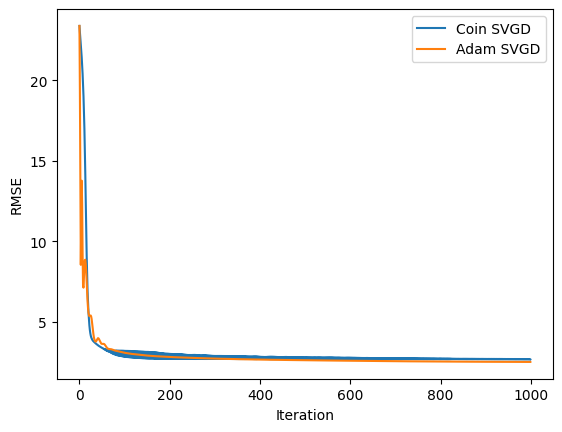

In [33]:
def rmse_trace(particles):
    return vmap(lambda x_hat: jnp.sqrt(jnp.mean((y_test - vmap(lambda x: model.predict(x, X_test))(x_hat).mean(0)) ** 2)))(particles)

plt.plot(rmse_trace(x_coin), label="Coin SVGD")
#plt.plot(rmse_trace(x_pgd), label="PGD")
plt.plot(rmse_trace(x_adam), label="Adam SVGD")
#plt.plot(rmse_trace(x_soul), label="Soul")

plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.legend()

In [35]:
rmse_trace(x_coin)

Array([23.387274 , 23.001022 , 22.634966 , 22.26111  , 21.866026 ,
       21.433994 , 20.950958 , 20.396832 , 19.752533 , 18.991177 ,
       18.08087  , 16.986338 , 15.663125 , 14.1028385, 12.360562 ,
       10.633447 ,  9.116371 ,  7.8562665,  6.8814273,  6.150949 ,
        5.5832176,  5.128361 ,  4.768574 ,  4.4932113,  4.287288 ,
        4.137098 ,  4.028047 ,  3.9489598,  3.8901045,  3.84455  ,
        3.8069208,  3.7743459,  3.7452826,  3.7184289,  3.6924918,
        3.6674569,  3.643396 ,  3.619662 ,  3.5960584,  3.5730586,
        3.5507371,  3.5289662,  3.5087934,  3.4880998,  3.4697337,
        3.4487412,  3.4329278,  3.4109573,  3.4014924,  3.383668 ,
        3.3684285,  3.347155 ,  3.3372595,  3.3116603,  3.3124635,
        3.2795746,  3.2865987,  3.248205 ,  3.268885 ,  3.2094898,
        3.265436 ,  3.1798778,  3.2392306,  3.1555114,  3.2232254,
        3.1318197,  3.2015958,  3.108215 ,  3.1891932,  3.0773134,
        3.1875987,  3.0482852,  3.1839008,  3.0188437,  3.1877